# Requirements and Imports

In [1]:
!pip install -r requirements.txt

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [2]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

import tensorflow as tf
import keras_tuner as kt

#TF-IDF Import
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Machine Learning Model Import:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Deep Learning Model 1 Import:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, LSTMCell, RNN, Dense, SpatialDropout1D, Concatenate, Flatten, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Transformer Embeddings Import:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification,DistilBertModel
# Deep Learning Model 2 Import:
from transformers import AutoModelForSequenceClassification, AutoConfig, DebertaV2Tokenizer, AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer


import evaluate
from datasets import Dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time

print("imports done")

imports done


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
from torch.utils.data import Dataset
torch.cuda.set_device(0)

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is NOT available")

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

True
NVIDIA A100-SXM4-40GB
GPU is available


# Data Creation for Different Sub Problems

In [4]:
import pandas as pd

bodies_df = pd.read_csv('train_bodies.csv')
stances_df = pd.read_csv('train_stances.csv')


master = pd.merge(stances_df, bodies_df, on='Body ID', how='left')


mastertxt = 'master.csv'
master.to_csv(mastertxt, index=False)


In [5]:

master_df = pd.read_csv('master.csv')


stage1_df = master_df.copy()
stage1_df['Stance'] = stage1_df['Stance'].replace(['agree', 'disagree', 'discuss'], 'related')

stage1_df.to_csv('stage1.csv', index=False)


stage2_df = master_df[master_df['Stance'] != 'unrelated']

stage2_df.to_csv('stage2.csv', index=False)

print("Stage1 and Stage2 files have been created.")

stage1_df.head()
stage2_df.head()

Stage1 and Stage2 files have been created.


,Headline,Body ID,Stance,articleBody
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree,Thousands of people have been duped by a fake ...
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree,If you’ve seen a story floating around on your...
10,Gateway Pundit,2327,discuss,A British rapper whose father is awaiting tria...


In [6]:
import pandas as pd

bodies_df = pd.read_csv('competition_test_bodies.csv')
stances_df = pd.read_csv('competition_test_stances.csv')



master = pd.merge(stances_df, bodies_df, on='Body ID', how='left')


mastertxt = 'master_test.csv'
master.to_csv(mastertxt, index=False)

master.head()


,Headline,Body ID,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated,Dave Morin's social networking company Path is...
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated,A bereaved Afghan mother took revenge on the T...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated,Hewlett-Packard is officially splitting in two...
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated,An airline passenger headed to Dallas was remo...


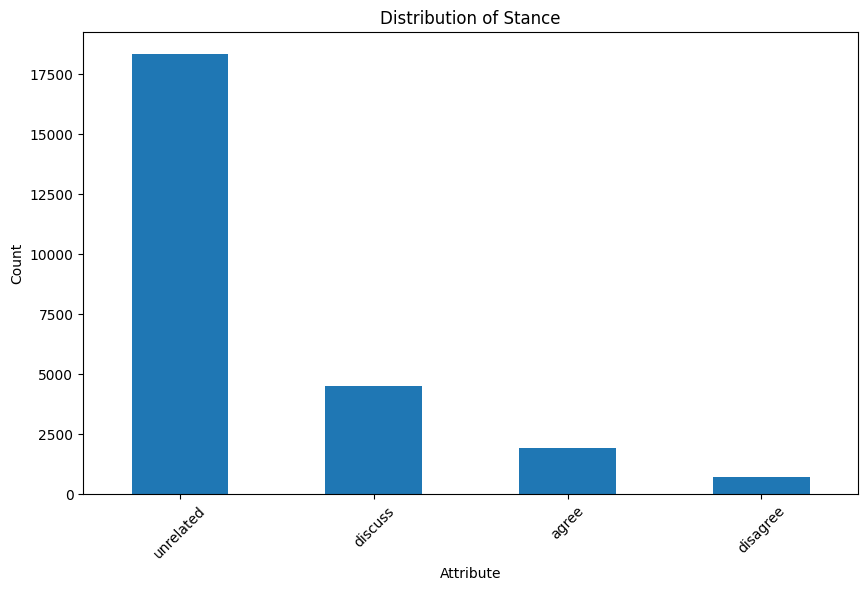

In [7]:
import matplotlib.pyplot as plt
df = pd.read_csv('master_test.csv')
feature_name = 'Stance'


attribute_counts = df[feature_name].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
attribute_counts.plot(kind='bar')
plt.title(f'Distribution of {feature_name}')
plt.xlabel('Attribute')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

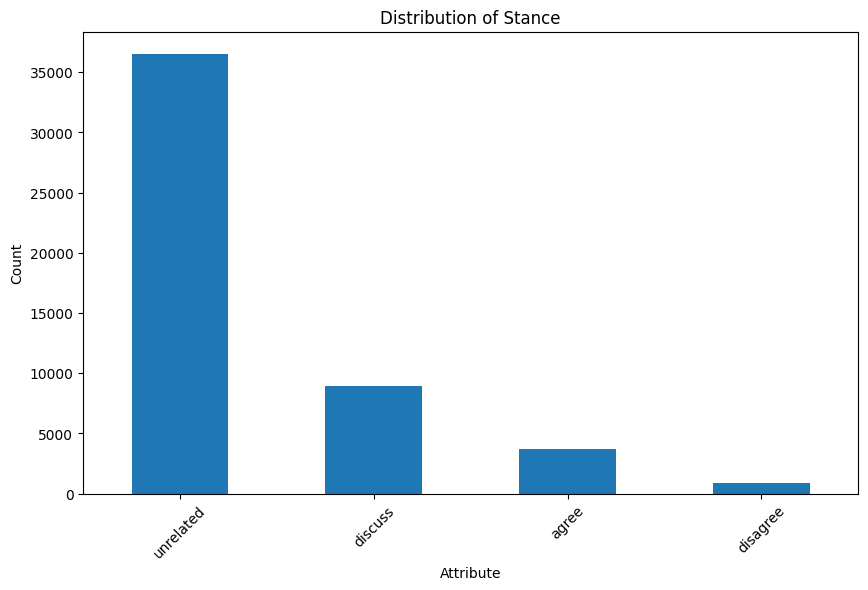

In [8]:
df = pd.read_csv('master.csv')
feature_name = 'Stance'


attribute_counts = df[feature_name].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
attribute_counts.plot(kind='bar')
plt.title(f'Distribution of {feature_name}')
plt.xlabel('Attribute')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [9]:

master_df = pd.read_csv('master_test.csv')


stage1_df = master_df.copy()
stage1_df['Stance'] = stage1_df['Stance'].replace(['agree', 'disagree', 'discuss'], 'related')

stage1_df.to_csv('stage1_test.csv', index=False)


stage2_df = master_df[master_df['Stance'] != 'unrelated']

stage2_df.to_csv('stage2_test.csv', index=False)

print("Stage1 and Stage2 files have been created.")

stage1_df.head()

Stage1 and Stage2 files have been created.


,Headline,Body ID,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated,Dave Morin's social networking company Path is...
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated,A bereaved Afghan mother took revenge on the T...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated,Hewlett-Packard is officially splitting in two...
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated,An airline passenger headed to Dallas was remo...


# DistilBERT embeddings

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

def get_distilbert_embeddings(texts):
    """Generate DistilBERT embeddings on the specified device (GPU/CPU)."""
    model.eval()
    embeddings = []

    for text in texts:
        # Encode text on the CPU
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        # Move encoded tensors to the same device as model
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # Extract embeddings, moving the tensor back to the CPU for compatibility with numpy
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy())

    return np.array(embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
df = pd.read_csv('stage1.csv')
headlines = df['Headline']
article_bodies = df['articleBody']

# Get embeddings
headline_embeddings = get_distilbert_embeddings(headlines)
article_body_embeddings = get_distilbert_embeddings(article_bodies)

stance_map = {'unrelated': 0, 'related': 1}
df['label'] = df['Stance'].map(stance_map)

# Combine embeddings
features = np.concatenate([headline_embeddings, article_body_embeddings], axis=1)

labels = np.array(df['label'].tolist())

print("DistilBERT Embeddings Computed")

DistilBERT Embeddings Computed


# SVC on DistilBERT embeddings*

Accuracy: 0.9927963981990996
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7333
           1       0.99      0.99      0.99      2662

    accuracy                           0.99      9995
   macro avg       0.99      0.99      0.99      9995
weighted avg       0.99      0.99      0.99      9995



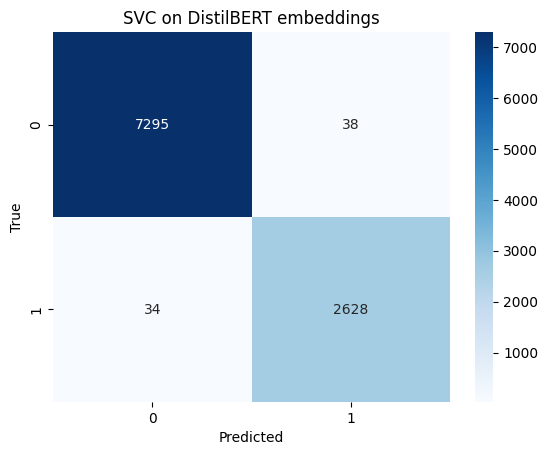

In [12]:
# IMPORTANT USE THESE  METRICS
DBX_train, DBX_test, DBy_train, DBy_test = train_test_split(features, labels, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(DBX_train)
X_test_scaled = scaler.transform(DBX_test)

svc = SVC(kernel='rbf', random_state=42)
svc.fit(X_train_scaled, DBy_train)

predictions = svc.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(DBy_test, predictions)}")

# Evaluation metrics
print(classification_report(DBy_test, predictions))

# Plotting the confusion matrix
conf_mat = confusion_matrix(DBy_test, predictions)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(DBy_train), yticklabels=np.unique(DBy_train))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVC on DistilBERT embeddings')
plt.show()

# SVC using TF-IDF with Cosine Similarity

Accuracy: 0.9775887943971986
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7333
           1       0.96      0.95      0.96      2662

    accuracy                           0.98      9995
   macro avg       0.97      0.97      0.97      9995
weighted avg       0.98      0.98      0.98      9995



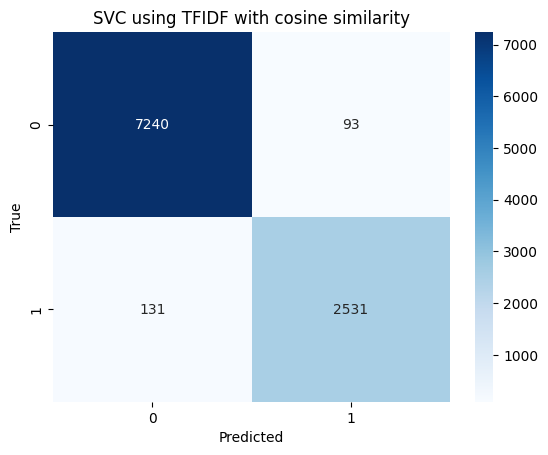

In [13]:
#df = pd.read_csv('stage1.csv')
combined_texts = pd.concat([df['Headline'], df['articleBody']]).unique()
tfidf_vectorizer = TfidfVectorizer(stop_words='english')


tfidf_vectorizer.fit(combined_texts)

tfidf_headlines = tfidf_vectorizer.transform(df['Headline'])
tfidf_bodies = tfidf_vectorizer.transform(df['articleBody'])

# Calculate cosine similarities and transform to distances
cosine_similarities = cosine_similarity(tfidf_headlines, tfidf_bodies)
cosine_distances = 1 - cosine_similarities.diagonal()

X = cosine_distances.reshape(-1, 1)  # Feature matrix needs to be 2D
y = df['Stance'].apply(lambda x: 1 if x == 'related' else 0).values

# IMPORTANT, USE THESE VALIDATION METRICS
TFX_train, TFX_test, TFy_train, TFy_test = train_test_split(X, y, test_size=0.2, random_state=42)

svc = SVC(kernel='rbf')
svc.fit(TFX_train, TFy_train)

y_pred = svc.predict(TFX_test)

print(f"Accuracy: {accuracy_score(TFy_test, y_pred)}")
# Evaluation metrics
print(classification_report(TFy_test, y_pred))

# Plotting the confusion matrix
conf_mat = confusion_matrix(TFy_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(TFy_train), yticklabels=np.unique(TFy_train))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVC using TFIDF with cosine similarity')
plt.show()

# LSTM with DistilBERT embeddings

In [14]:
stance_map = {'unrelated': 0, 'related': 1}
df['label'] = df['Stance'].map(stance_map)

labels = np.array(df['label'].tolist())

stances = df['label'].values

label_encoder = LabelEncoder()
stances_encoded = label_encoder.fit_transform(stances)
y_encoded = to_categorical(stances_encoded)

Ensure that we are training the LSTMs on the GPU

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 17026 (66.51 KB)
Trainable params: 17026 (66.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 19s 54ms/step - loss: 0.6057 - accuracy: 0.7268 - val_loss: 0.5808 - val_accuracy: 0.7337
Epoch 2/20
313/313 [==============================] - 16s 52ms/step - loss: 0.5831 - accuracy: 0.7307 - val_loss: 0.5795 - val_accuracy: 0.7337
Epoch 3/20
313/313 [==============================] - 16s 52ms/step - loss: 0.5830 - accuracy: 0.7307 - val_loss: 0.5798 - val_a

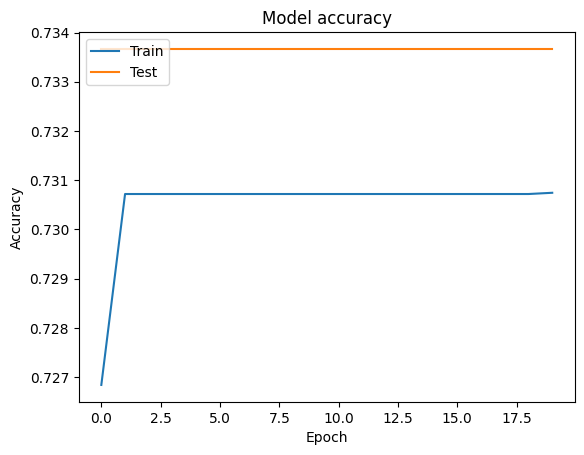

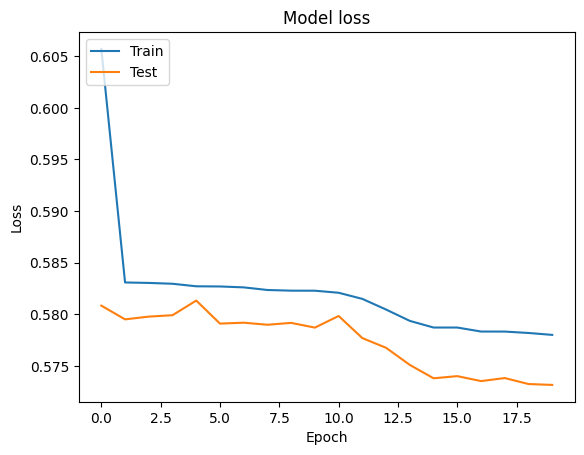

In [16]:
#DBX_train, DBX_test, DBy_train, DBy_test = train_test_split(features, labels, test_size=0.2, random_state=42)

embedding_input_shape = features.shape[1]
num_classes = 2  # Adjust based on your dataset

DBX_train, DBX_test, DBy_train, DBy_test = train_test_split(features, y_encoded, test_size=0.2, random_state=42)

def create_lstm_model_for_embeddings(input_shape, num_classes):
    model = Sequential([
        LSTM(64, input_shape=(input_shape, 1)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_embeddings = create_lstm_model_for_embeddings(embedding_input_shape, num_classes)
model_embeddings.summary()
timesteps = 1  
features = embedding_input_shape  
num_classes = 2  


history = model_embeddings.fit(
    DBX_train, DBy_train,
    validation_data=(DBX_test, DBy_test),
    epochs=20,
    batch_size=128,
    workers=24, 
    use_multiprocessing=True,
    validation_split=0.2
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

313/313 [==============================] - 6s 19ms/step


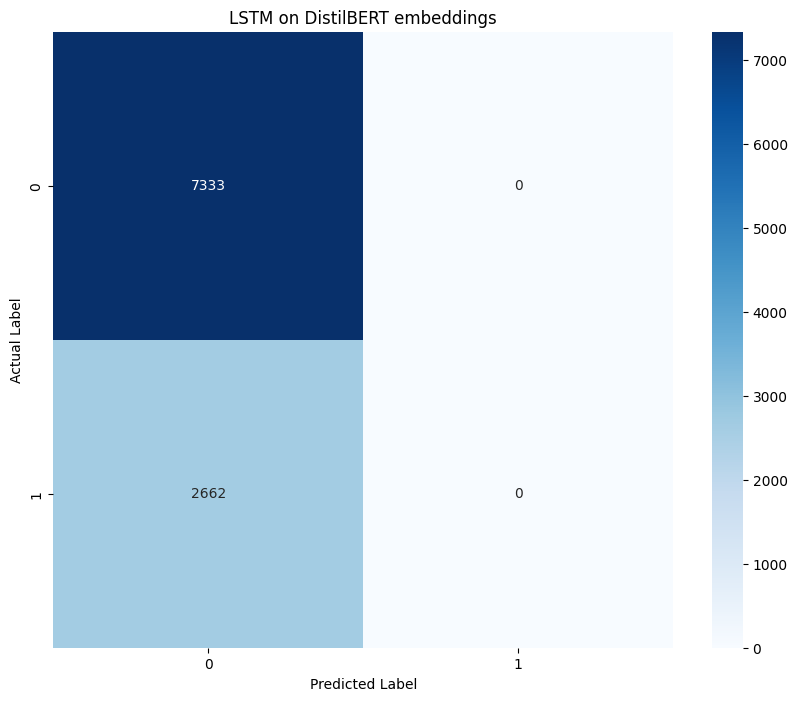

Classification Report
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      7333
           1       0.00      0.00      0.00      2662

    accuracy                           0.73      9995
   macro avg       0.37      0.50      0.42      9995
weighted avg       0.54      0.73      0.62      9995



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:

Y_pred = model_embeddings.predict(DBX_test)

Y_pred_classes = np.argmax(Y_pred, axis=1)

Y_true = np.argmax(DBy_test, axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d',cmap='Blues')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('LSTM on DistilBERT embeddings')
plt.show()

print('Classification Report')
print(classification_report(Y_true, Y_pred_classes))

# LSTM with TF-IDF Cosine Sim Distances

In [18]:
cosine_similarities = [cosine_similarity(tfidf_headline, tfidf_body).flatten()[0] for tfidf_headline, tfidf_body in zip(tfidf_headlines, tfidf_bodies)]
df['cosine_similarity'] = cosine_similarities

In [19]:
cosine_similarities_reshaped = df['cosine_similarity'].values.reshape(-1, 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17026 (66.51 KB)
Trainable params: 17026 (66.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 3s 5ms/step - loss: 0.4793 - accuracy: 0.7740 - val_loss: 0.2767 - val_accuracy: 0.9079
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 0.1762 - accuracy: 0.9448 - val_loss: 0.1148 - val_accuracy: 0.9670
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 0.1081 - accuracy: 0.9668 - val_loss: 0.0890 - val_accur

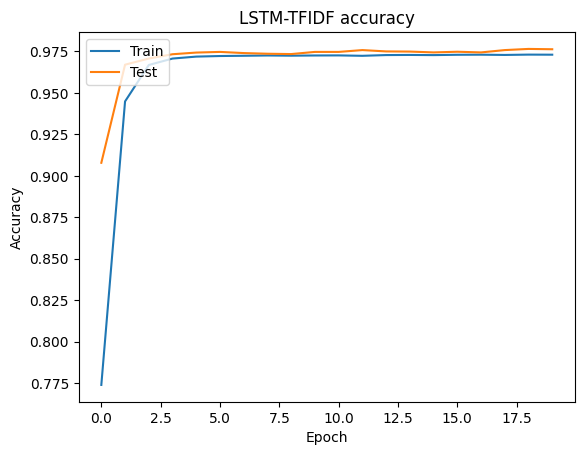

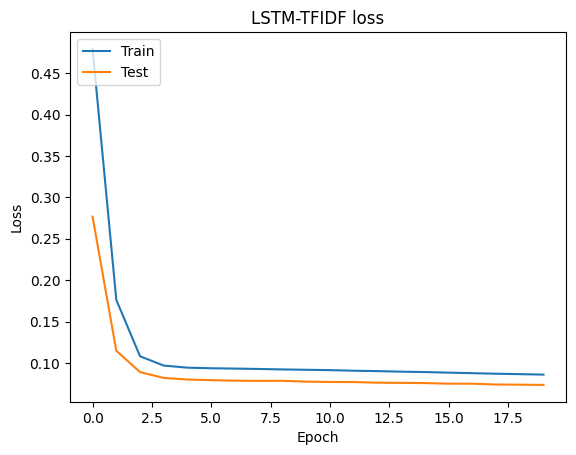

In [20]:
def create_lstm_model_for_tfidf(input_shape, num_classes):
    model = Sequential([
        LSTM(64, input_shape=(input_shape, 1)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


tfidf_input_shape = 1


X_tfidf = cosine_similarities_reshaped.reshape((-1, tfidf_input_shape, 1))
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)


model_tfidf = create_lstm_model_for_tfidf(tfidf_input_shape, y_encoded.shape[1])
model_tfidf.summary()
history = model_tfidf.fit(X_tfidf_train, y_tfidf_train, validation_data=(X_tfidf_test, y_tfidf_test), epochs=20, batch_size=128, validation_split=0.2)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM-TFIDF accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM-TFIDF loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
test_loss, test_accuracy = model_tfidf.evaluate(X_tfidf_test, y_tfidf_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

313/313 [==============================] - 1s 2ms/step - loss: 0.0735 - accuracy: 0.9763
Test Loss: 0.07349137961864471
Test Accuracy: 0.9762881398200989


313/313 [==============================] - 1s 2ms/step


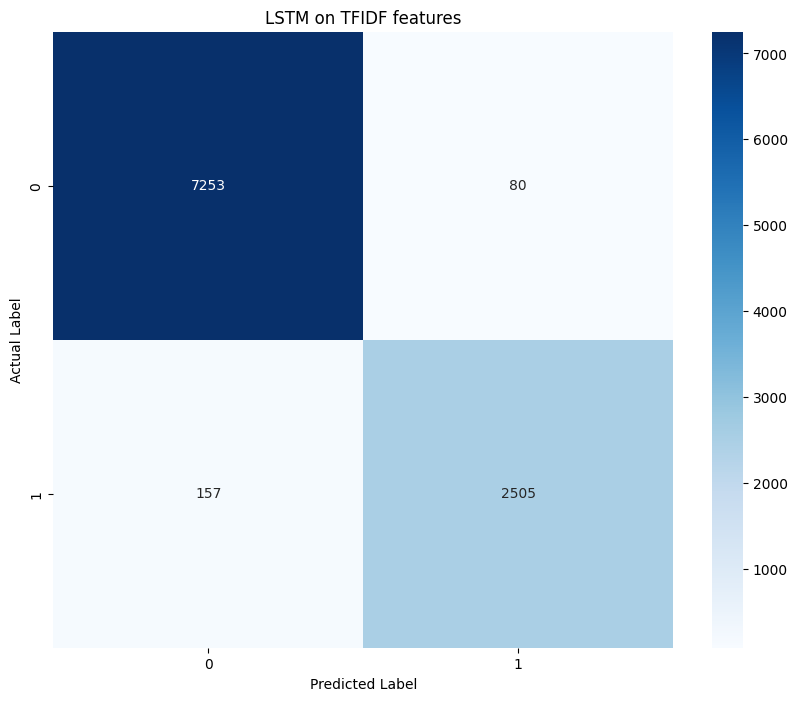

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7333
           1       0.97      0.94      0.95      2662

    accuracy                           0.98      9995
   macro avg       0.97      0.97      0.97      9995
weighted avg       0.98      0.98      0.98      9995



In [22]:

Y_pred = model_tfidf.predict(X_tfidf_test)

Y_pred_classes = np.argmax(Y_pred, axis=1)

Y_true = np.argmax(y_tfidf_test, axis=1)


confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d',cmap='Blues')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('LSTM on TFIDF features')
plt.show()

# Print the classification report
print('Classification Report')
print(classification_report(Y_true, Y_pred_classes))

# DeBERTa V3 Multi Class Classification*

In [23]:
from transformers import AutoModelForSequenceClassification, AutoConfig, DebertaV2Tokenizer

model_name = 'microsoft/deberta-v3-large'
config = AutoConfig.from_pretrained(model_name, num_labels=3)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True)
tokenizer = DebertaV2Tokenizer.from_pretrained(model_name)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
df = pd.read_csv('stage2.csv')
df['text'] = df['Headline'] + " " + df['articleBody']
stance_map = {'agree': 0, 'disagree': 1, 'discuss':2}
df['label'] = df['Stance'].map(stance_map)
df.head()

,Headline,Body ID,Stance,articleBody,text,label
0,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...,Hundreds of Palestinians flee floods in Gaza a...,0
1,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's...",Spider burrowed through tourist's stomach and ...,1
2,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree,Thousands of people have been duped by a fake ...,'Nasa Confirms Earth Will Experience 6 Days of...,0
3,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree,If you’ve seen a story floating around on your...,Banksy 'Arrested & Real Identity Revealed' Is ...,0
4,Gateway Pundit,2327,discuss,A British rapper whose father is awaiting tria...,Gateway Pundit A British rapper whose father i...,2


In [25]:
from datasets import Dataset
df_train,df_test = train_test_split(df,test_size=0.2)
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

max_length = 512

def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=max_length)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10741 [00:00<?, ? examples/s]

Map:   0%|          | 0/2686 [00:00<?, ? examples/s]

In [26]:
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    results = {}
    results["accuracy"] = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    results["precision"] = precision.compute(predictions=predictions, references=labels, average="macro")["precision"]
    results["recall"] = recall.compute(predictions=predictions, references=labels, average="macro")["recall"]
    results["f1"] = f1.compute(predictions=predictions, references=labels, average="macro")["f1"]
    return results

In [27]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=6e-06,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    seed=42,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    optim="adamw_torch",
    lr_scheduler_type="linear",
    warmup_steps=50,
    fp16=True if torch.cuda.is_available() else False,  # Enable mixed precision training if CUDA is available
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.444100,0.195272,0.949367,0.910667,0.932610,0.921090
2,0.133400,0.109296,0.979896,0.968859,0.964772,0.966698
3,0.064200,0.100904,0.982130,0.960599,0.980982,0.970464
4,0.028000,0.071997,0.988086,0.971969,0.984499,0.978118
5,0.013800,0.060118,0.988459,0.971486,0.985588,0.978359


TrainOutput(global_step=6715, training_loss=0.13670943395823396, metrics={'train_runtime': 2556.5941, 'train_samples_per_second': 21.006, 'train_steps_per_second': 2.627, 'total_flos': 4.986514907492454e+16, 'train_loss': 0.13670943395823396, 'epoch': 5.0})

In [28]:
trainer.evaluate()

{'eval_loss': 0.06011824682354927,
 'eval_accuracy': 0.9884586746090841,
 'eval_precision': 0.9714860785658006,
 'eval_recall': 0.9855876706952142,
 'eval_f1': 0.9783586800851491,
 'eval_runtime': 33.9992,
 'eval_samples_per_second': 79.002,
 'eval_steps_per_second': 9.883,
 'epoch': 5.0}

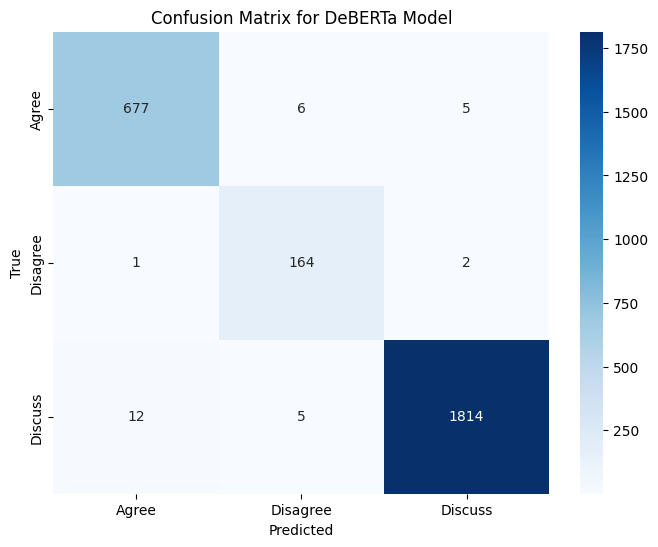

              precision    recall  f1-score   support

       Agree       0.98      0.98      0.98       688
    Disagree       0.94      0.98      0.96       167
     Discuss       1.00      0.99      0.99      1831

    accuracy                           0.99      2686
   macro avg       0.97      0.99      0.98      2686
weighted avg       0.99      0.99      0.99      2686



In [33]:
predictions = trainer.predict(tokenized_test)

predicted_class_indices = np.argmax(predictions.predictions, axis=1)

true_labels = predictions.label_ids

conf_mat = confusion_matrix(true_labels, predicted_class_indices)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Agree', 'Disagree', 'Discuss'],
            yticklabels=['Agree', 'Disagree', 'Discuss'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for DeBERTa Model')
plt.show()

report = classification_report(true_labels, predicted_class_indices, target_names=['Agree', 'Disagree', 'Discuss'])
print(report)

In [29]:
trainer.save_model('Deep-Learning-2')

# End to End Test*

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

def get_distilbert_embeddings(texts):
    """Generate DistilBERT embeddings on the specified device (GPU/CPU)."""
    model.eval()
    embeddings = []

    for text in texts:
        # Encode text on the CPU
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        # Move encoded tensors to the same device as model
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # Extract embeddings, moving the tensor back to the CPU for compatibility with numpy
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy())

    return np.array(embeddings)

In [38]:
df = pd.read_csv('stage1.csv')
df_test = pd.read_csv('stage1_test.csv')
df_master_test = pd.read_csv('master_test.csv')

headlines = df['Headline']
article_bodies = df['articleBody']
headlines_test = df_test['Headline']
article_bodies_test = df_test['articleBody']

# Get embeddings for the test set and training set
headline_embeddings = get_distilbert_embeddings(headlines)
article_body_embeddings = get_distilbert_embeddings(article_bodies)
headline_embeddings_test = get_distilbert_embeddings(headlines_test)
article_body_embeddings_test = get_distilbert_embeddings(article_bodies_test)

stance_map = {'unrelated': 0, 'related': 1}
df['label'] = df['Stance'].map(stance_map)
df_test['label'] = df_test['Stance'].map(stance_map)

features = np.concatenate([headline_embeddings, article_body_embeddings], axis=1)
features_test = np.concatenate([headline_embeddings_test, article_body_embeddings_test], axis=1)

labels = np.array(df['label'].tolist())

labels_test = np.array(df_test['label'].tolist())

In [39]:
print(features.shape)  # Should be (num_samples_train, 1536)
print(features_test.shape)  # Should be (num_samples_test, 1536)
print(scaler.transform(features).shape)  # Used to train the model
# IMPORTANT USE THESE  METRICS
DBX_train, DBX_test, DBy_train, DBy_test = train_test_split(features, labels, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(DBX_train)
X_test_scaled = scaler.transform(DBX_test)

print(X_test_scaled.shape)

svc = SVC(kernel='rbf', random_state=42)
svc.fit(X_train_scaled, DBy_train)

predictions = svc.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(DBy_test, predictions)}")


Accuracy: 0.9927963981990996


In [40]:
scaler = StandardScaler().fit(features)  

X_test_scaled = scaler.transform(features_test)  

print(features)

predictions_svm = svc.predict(X_test_scaled)  

df_test['predicted_stance_svm'] = np.where(predictions_svm == 1, 'related', 'unrelated')

df_master_test['predicted_stance_svm'] = df_test['predicted_stance_svm']

df_filtered_master_test = df_master_test[df_master_test['predicted_stance_svm'] == 'related']

# Save the filtered dataset to a new CSV fil
df_filtered_master_test.to_csv('filtered_master_test.csv', index=False)

[[ 0.12915292  0.02249383  0.21844138 ...  0.0333596   0.1216177
  -0.18607315]
 [ 0.15091108  0.19831887 -0.30727172 ... -0.12195297 -0.0672053
   0.12733774]
 [-0.03889182 -0.1215758   0.1342235  ... -0.05644751  0.11591814
   0.12275327]
 ...
 [ 0.04942514 -0.00294804 -0.05366257 ...  0.00813738  0.13784556
   0.03592826]
 [ 0.10801385 -0.21628809  0.03593106 ...  0.06515153  0.10035031
  -0.12622471]
 [ 0.19416177 -0.01519726 -0.1348149  ... -0.10693636  0.0362012
   0.00901031]]


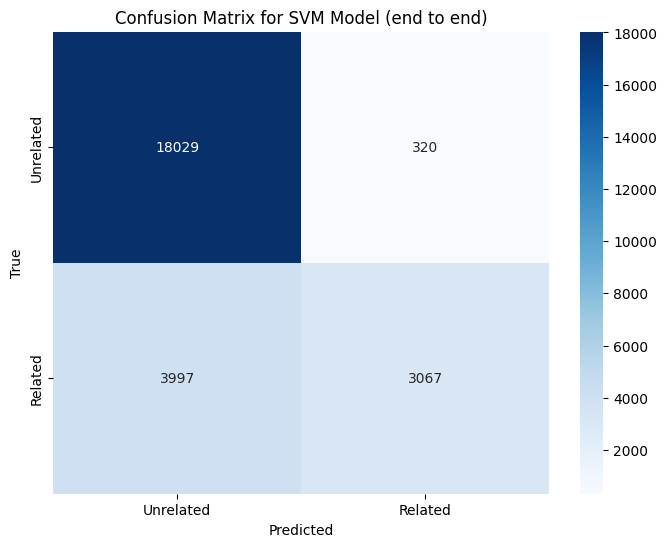

              precision    recall  f1-score   support

   Unrelated       0.82      0.98      0.89     18349
     Related       0.91      0.43      0.59      7064

    accuracy                           0.83     25413
   macro avg       0.86      0.71      0.74     25413
weighted avg       0.84      0.83      0.81     25413



In [41]:
df_test['true_label'] = df_test['Stance'].map(stance_map)
true_labels_test = df_test['true_label'].values

conf_mat = confusion_matrix(true_labels_test, predictions_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unrelated', 'Related'], yticklabels=['Unrelated', 'Related'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM Model (end to end)')
plt.show()

report = classification_report(true_labels_test, predictions_svm, target_names=['Unrelated', 'Related'])
print(report)


In [42]:
from transformers import pipeline


model_checkpoint = 'Deep-Learning-2'
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)


df_filtered_master_test['text'] = df_filtered_master_test['Headline'] + " " + df_filtered_master_test['articleBody']
predictions_dl = classifier(df_filtered_master_test['text'].tolist())


predicted_labels = [pred['label'] for pred in predictions_dl]
df_filtered_master_test['predicted_stance_dl'] = predicted_labels


label_map_reverse = {0: 'agree', 1: 'disagree', 2: 'discuss'}
df_filtered_master_test['predicted_stance_dl'] = df_filtered_master_test['predicted_stance_dl'].apply(lambda x: label_map_reverse[int(x[-1])])

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
<ipython-input-42-d675aec58e5a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_master_test['text'] = df_filtered_master_test['Headline'] + " " + df_filtered_master_test['articleBody']
<ipython-input-42-d675aec58e5a>:17: SettingWithCopyWarning:

              precision    recall  f1-score   support

   unrelated       0.82      0.98      0.89     18349
       agree       0.76      0.27      0.40      1903
    disagree       0.58      0.09      0.16       697
     discuss       0.82      0.48      0.60      4464

    accuracy                           0.82     25413
   macro avg       0.74      0.46      0.51     25413
weighted avg       0.81      0.82      0.78     25413



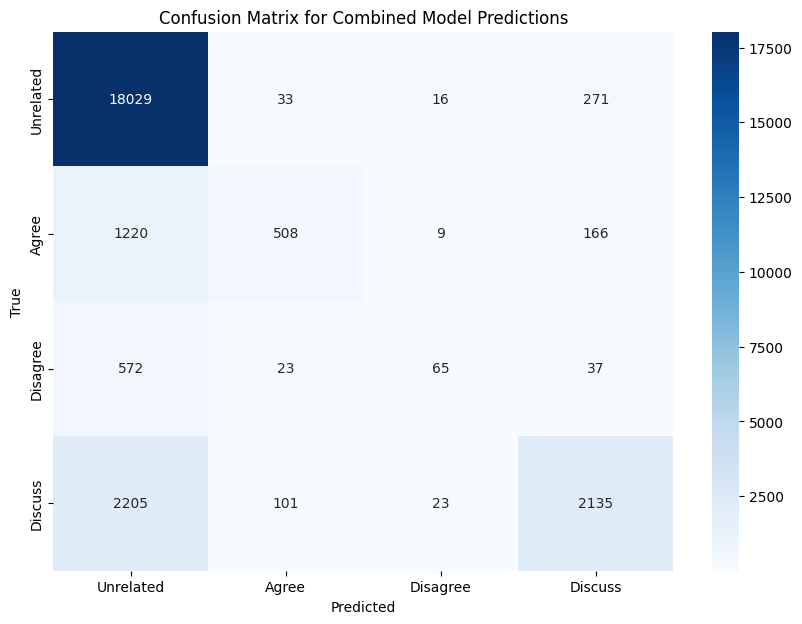

In [43]:
# Step 1: Add a placeholder for DL model predictions to df_test
df_test['predicted_stance_dl'] = 'unrelated'

# Step 2: Update this column for articles classified as 'related' by the ML model
# with their respective DL model predictions
df_test.loc[df_test['predicted_stance_svm'] == 'related', 'predicted_stance_dl'] = df_filtered_master_test['predicted_stance_dl'].values


# If 'related', use the DL model's prediction; otherwise, use 'unrelated'
df_test['final_prediction'] = df_test.apply(lambda x: x['predicted_stance_dl'] if x['predicted_stance_svm'] == 'related' else 'unrelated', axis=1)

# Load the true labels
df_master_test = pd.read_csv('master_test.csv')
true_labels = df_master_test['Stance'].values


# Generate the classification report
report = classification_report(true_labels, df_test['final_prediction'], labels=['unrelated', 'agree', 'disagree', 'discuss'])
print(report)

# Generate and plot the confusion matrix
conf_mat = confusion_matrix(true_labels, df_test['final_prediction'], labels=['unrelated', 'agree', 'disagree', 'discuss'])
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unrelated', 'Agree', 'Disagree', 'Discuss'], yticklabels=['Unrelated', 'Agree', 'Disagree', 'Discuss'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Combined Model Predictions')
plt.show()